In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import sys
print(sys.executable)
sys.path.insert(1, '../src/')
from config import raw_data_path, univariate_data_path, processed_data_path, models_path
from preprocessing_modules import create_time_windows_with_labels
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import matplotlib.pyplot as plt
from FCMAE_model import FCMAE


/home/nwertheim/miniconda3/bin/python
/home/nwertheim/miniconda3/bin/python


In [4]:
'''MY DATA'''
train_dir = os.path.join(univariate_data_path, "target_univariate_no_PCA_train.npy")
train_data = np.load(train_dir, allow_pickle=True)
# train_data = pd.DataFrame(train_data)
test_dir = os.path.join(univariate_data_path, "target_univariate_no_PCA_test.npy")
test_data = np.load(test_dir, allow_pickle=True)
# test_data = pd.DataFrame(test_data)
print(len(train_data))
print(len(test_data))
print(train_data[0])
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.utils.class_weight import compute_class_weight

from collections import Counter

# Example dataset with windows and labels
train_windows, train_labels = create_time_windows_with_labels(train_data)
test_windows, test_labels = create_time_windows_with_labels(test_data)

# Count label distribution
train_label_counts = Counter(train_labels)
test_label_counts = Counter(test_labels)

# Print the counts
print("Train label distribution:")
print(f"  Term (0): {train_label_counts[0]}")
print(f"  Preterm (1): {train_label_counts[1]}")

print("\nTest label distribution:")
print(f"  Term (0): {test_label_counts[0]}")
print(f"  Preterm (1): {test_label_counts[1]}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Convert to tensors
train_windows_tensor = torch.tensor(train_windows, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32)
test_windows_tensor = torch.tensor(test_windows, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32)

train_windows_tensor = train_windows_tensor.unsqueeze(1)  # (1071, 1, 12000)
test_windows_tensor = test_windows_tensor.unsqueeze(1)    # (899, 1, 12000)

train_labels_tensor = train_labels_tensor.long()
test_labels_tensor = test_labels_tensor.long()


print(train_labels_tensor.shape)

train_dataset = TensorDataset(train_windows_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_windows_tensor, test_labels_tensor)

# Create DataLoaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



684
174
{'record_name': 'Hopper-2023_03_06_19_35_18-0000010181-0000-chan0', 'signal': array([[30.26377405],
       [51.72742573],
       [38.71189734],
       ...,
       [-1.23572809],
       [ 2.92797998],
       [-4.08031036]]), 'fs': 20, 'preterm': 0}
Train label distribution:
  Term (0): 2094
  Preterm (1): 6270

Test label distribution:
  Term (0): 600
  Preterm (1): 1614
torch.Size([8364])


In [6]:



# Load the pre-trained encoder
path = os.path.join(models_path, 'FCMAE_best_multiple_encoder_gpu.pth')

# Load the full FCMAE model
fcmae = FCMAE(in_channels=1, base_dim=128, num_blocks=5, kernel_size=9)


# Load the saved weights into the full model
state_dict = torch.load(path)
fcmae.load_state_dict(state_dict)

# Extract only the encoder from the FCMAE model
encoder = fcmae.encoder
# Set the encoder to evaluation mode and freeze the encoder parameters
encoder.eval()
for param in encoder.parameters():
    param.requires_grad = False  # Freeze the encoder

print(encoder)

Sequential(
  (0): Conv1d(1, 128, kernel_size=(9,), stride=(2,), padding=(4,))
  (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv1d(128, 256, kernel_size=(9,), stride=(2,), padding=(4,))
  (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Conv1d(256, 512, kernel_size=(9,), stride=(2,), padding=(4,))
  (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Conv1d(512, 1024, kernel_size=(9,), stride=(2,), padding=(4,))
  (10): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Conv1d(1024, 2048, kernel_size=(9,), stride=(2,), padding=(4,))
  (13): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
)


/scratch-local/nwertheim.11575130/ipykernel_210778/174721023.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path)


In [7]:
'''OUTPUT SHAPE ENCODER'''
# dummy_input = torch.randn(4, 1, 12000)  # (batch_size, channels, sequence_length)
# with torch.no_grad():
#     encoded = encoder(dummy_input)
# print(encoded.shape)


torch.Size([4, 2048, 375])


epoch,train_loss,valid_loss,accuracy,time


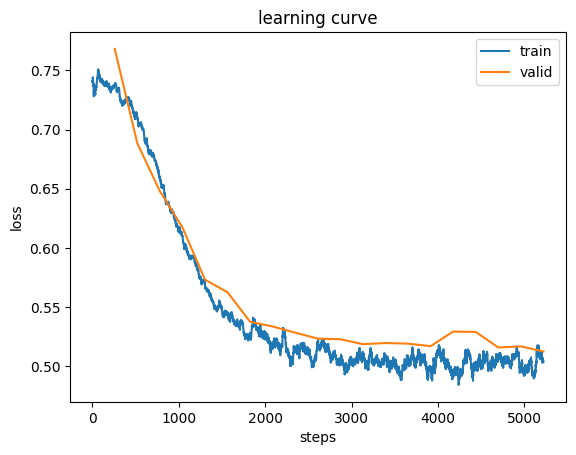

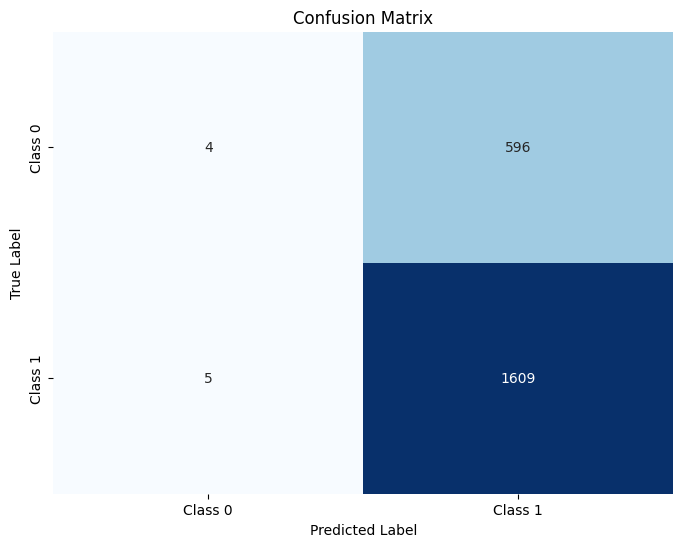

Accuracy: 0.7285
Precision: 0.7297
Recall: 0.9969
F1 Score: 0.8426
Average Precision (AP): 0.8996
Area Under ROC Curve (AUC): 0.7440


In [15]:
from tsai.models.ResNet import ResNet
from tsai.models import ResNet
from tsai.models.ResNet import ResNet
from fastai.metrics import accuracy
from fastai.data.core import DataLoaders
from fastai.learner import Learner
import torch

class FCMAEClassifier(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        self.classifier = ResNet(2048, 2)  # 2048 channels from encoder, 2 output classes

    def forward(self, x):
        with torch.no_grad():  # freeze encoder
            x = self.encoder(x)
        return self.classifier(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wrap your DataLoaders and set device
dls = DataLoaders.from_dsets(
    train_dataset,
    test_dataset,
    bs=32,
    shuffle=True,
    num_workers=0 
)

model = FCMAEClassifier(encoder)
model.to(device)

learn = Learner(dls, model, loss_func=torch.nn.CrossEntropyLoss(), metrics=accuracy)
learn.fit_one_cycle(20, 1e-6)

learn.recorder.plot_loss()  # Plot loss curves (training and validation loss)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch

# Get predictions and true labels
preds, targs = learn.get_preds(dl=learn.dls.valid)

# Convert predictions to class labels (argmax for multi-class classification)
pred_labels = preds.argmax(dim=1)

# Compute confusion matrix
cm = confusion_matrix(targs, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    average_precision_score,
    roc_auc_score
)

# Convert to numpy arrays if needed
true_labels = targs.cpu().numpy()
pred_labels = pred_labels.cpu().numpy()
pred_probs = preds[:, 1].cpu().numpy()  # Probability of class 1

# Compute metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, zero_division=0)
recall = recall_score(true_labels, pred_labels, zero_division=0)
f1 = f1_score(true_labels, pred_labels, zero_division=0)
ap = average_precision_score(true_labels, pred_probs)
auc = roc_auc_score(true_labels, pred_probs)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Average Precision (AP): {ap:.4f}")
print(f"Area Under ROC Curve (AUC): {auc:.4f}")



epoch,train_loss,valid_loss,accuracy,time
0,0.679133,0.683156,0.621951,00:02
1,0.663232,0.667949,0.618789,00:02
2,0.654773,0.652089,0.617435,00:02
3,0.634898,0.648963,0.525294,00:02
4,0.626487,0.622276,0.635953,00:02
5,0.620998,0.621531,0.578139,00:02
6,0.603818,0.605390,0.641825,00:02
7,0.610983,0.608060,0.616080,00:02
8,0.602623,0.600388,0.625113,00:02
9,0.610019,0.597184,0.626468,00:02


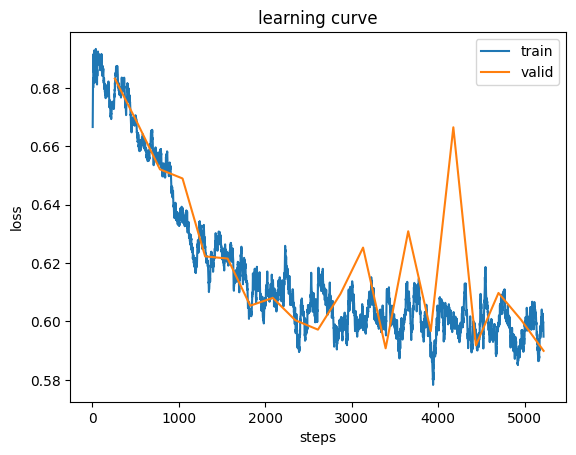

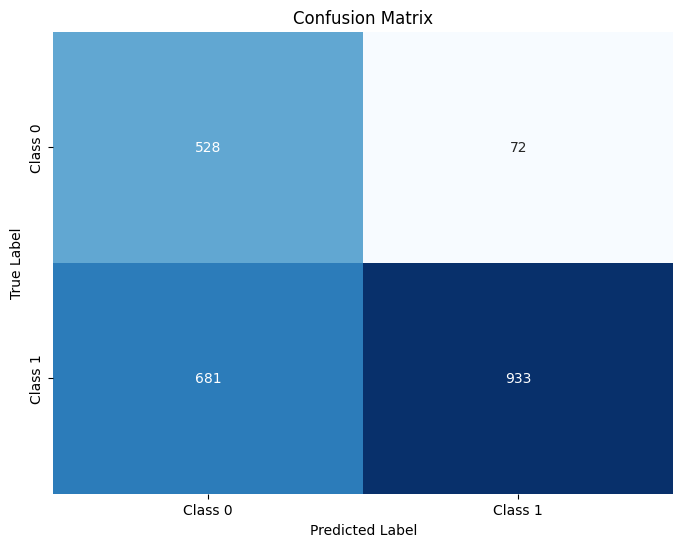

Accuracy: 0.6599
Precision: 0.9284
Recall: 0.5781
F1 Score: 0.7125
Average Precision (AP): 0.8923
Area Under ROC Curve (AUC): 0.7143


In [16]:
'''CLASS WEIGHTS'''
from tsai.models.ResNet import ResNet
from tsai.models import ResNet
from tsai.models.ResNet import ResNet
from fastai.metrics import accuracy
from fastai.data.core import DataLoaders
from fastai.learner import Learner
import torch

class FCMAEClassifier(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        self.classifier = ResNet(2048, 2)  # 2048 channels from encoder, 2 output classes

    def forward(self, x):
        with torch.no_grad():  # freeze encoder
            x = self.encoder(x)
        return self.classifier(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wrap your DataLoaders and set device
dls = DataLoaders.from_dsets(
    train_dataset,
    test_dataset,
    bs=32,
    shuffle=True,
    num_workers=0 
)

model = FCMAEClassifier(encoder)
model.to(device)

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Use weighted loss
loss_func = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

# Replace your loss function in the learner
learn = Learner(dls, model, loss_func=loss_func, metrics=accuracy)
learn.fit_one_cycle(20, 1e-6)

learn.recorder.plot_loss()  # Plot loss curves (training and validation loss)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch

# Get predictions and true labels
preds, targs = learn.get_preds(dl=learn.dls.valid)

# Convert predictions to class labels (argmax for multi-class classification)
pred_labels = preds.argmax(dim=1)

# Compute confusion matrix
cm = confusion_matrix(targs, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    average_precision_score,
    roc_auc_score
)

# Convert to numpy arrays if needed
true_labels = targs.cpu().numpy()
pred_labels = pred_labels.cpu().numpy()
pred_probs = preds[:, 1].cpu().numpy()  # Probability of class 1

# Compute metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, zero_division=0)
recall = recall_score(true_labels, pred_labels, zero_division=0)
f1 = f1_score(true_labels, pred_labels, zero_division=0)
ap = average_precision_score(true_labels, pred_probs)
auc = roc_auc_score(true_labels, pred_probs)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Average Precision (AP): {ap:.4f}")
print(f"Area Under ROC Curve (AUC): {auc:.4f}")

